In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

## Data Loading

In [2]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

--2024-10-29 07:39:18--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2024-10-29 07:39:18 (17.9 MB/s) - ‘airline-passengers.csv’ saved [2180/2180]



,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


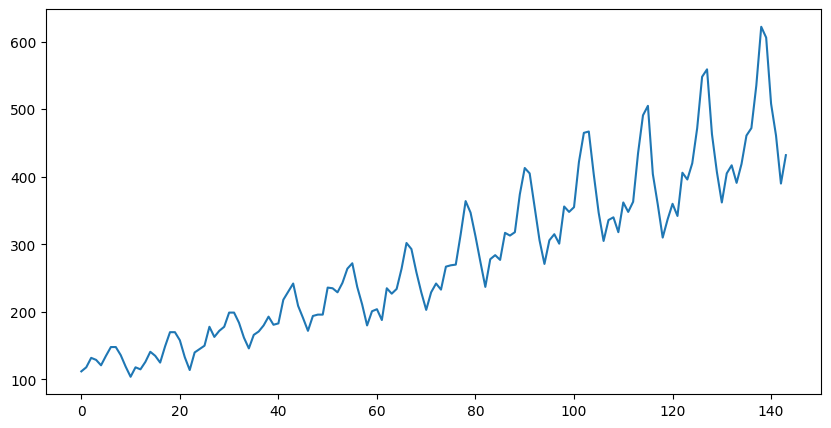

In [42]:
air_passengers = pd.read_csv('airline-passengers.csv')

air_passengers['Passengers'].plot(figsize=(10,5))

air_passengers.head()

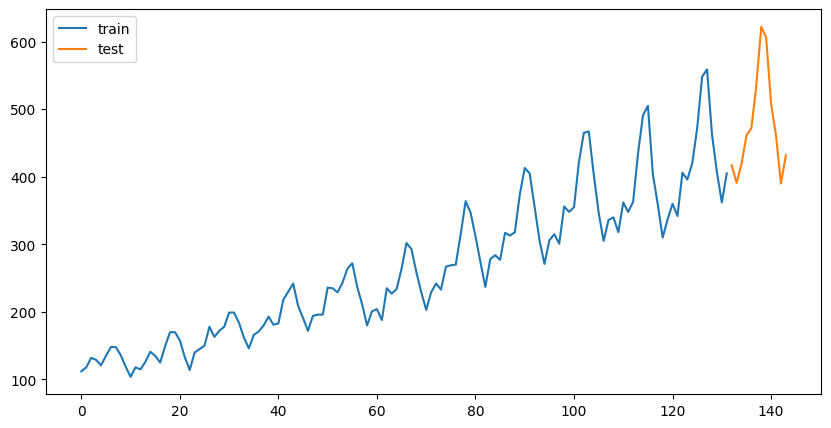

In [43]:
split = 1 # 년 단위

train = air_passengers[:-12*split]
data_train = train["Passengers"].to_numpy()

test = air_passengers[-12*split:]
data_test = test["Passengers"].to_numpy()

ax = train.plot(figsize=(10,5))
test.plot(ax=ax)

ax.legend(['train', 'test']);

In [44]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))

data_train = min_max_scaler.fit_transform(data_train.reshape(-1,1)).squeeze()
data_test = min_max_scaler.transform(data_test.reshape(-1,1)).squeeze()

air_passengers["Passengers_scaled"] = -1.0
air_passengers.loc[0:len(data_train)-1,"Passengers_scaled"] = data_train
air_passengers.loc[len(data_train):,"Passengers_scaled"] = data_test

## Dataset

In [45]:
class TimeDataset(Dataset):
    def __init__(self, y, input_window, output_window, stride):
        # 총 데이터의 개수
        N = y.shape[0]

        # stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (N - input_window - output_window) // stride + 1

        #input과 output
        X = np.zeros([num_samples, input_window])
        Y = np.zeros([num_samples, output_window])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1)
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1)
        self.x = X
        self.y = Y

        self.len = len(X)

    def __getitem__(self, i):
        return self.x[i], self.y[i]

    def __len__(self):
        return self.len

In [46]:
band = 3
# band년치 데이터를 보고 향후 1년치 데이터 예측
iw = 12*band
ow = 12

train_dataset = TimeDataset(data_train, input_window=iw, output_window=ow, stride=1)
train_loader = DataLoader(train_dataset, batch_size=32)

In [47]:
train_loader_iter = iter(train_loader)
batch = next(train_loader_iter)
# X                  y
batch[0].shape, batch[1].shape

(torch.Size([32, 36, 1]), torch.Size([32, 12, 1]))

## Transformer Encoder Model

In [48]:
import random

def set_seed(seed=42):
    """모든 난수 생성기의 시드를 설정하는 함수."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(42)

In [49]:
class TFModel(nn.Module):
    def __init__(self, iw, ow, d_model, nhead, nlayers, dropout=0.5):
        super(TFModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            self.encoder_layer, num_layers=nlayers
        )
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        # 원본 입력데이터로 부터 트랜스포머 인코더로 입력될 데이터를 인코딩 하는 층
        # (N, iw, 1)->(N, iw, 8)->(N, iw, 16)
        self.encoder = nn.Sequential(
            nn.Linear(1, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, d_model)
        )

        # 트랜스포머 인코더 이후 출력을 만들기 위한 Linear 층
        # (N, iw, 16)->(N, iw, 8)->(N, iw, 1)
        self.linear1 =  nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, 1)
        )

        # iw를 ow로 변환
        # (N, iw)->(N, (iw+ow)//2)->(N, ow)
        self.linear2 = nn.Sequential(
            nn.Linear(iw, (iw+ow)//2),
            nn.ReLU(),
            nn.Linear((iw+ow)//2, ow)
        )

    def generate_square_subsequent_mask(self, sz):
        # 인코더만 사용하는 시계열 데이터이므로 인코더 마스크도 코잘 마스크로 작성
        # 어텐션 스코어에 덧셈으로 마스크를 씌움
        # tensor([[0., -inf , -inf , -inf , -inf],
        #         [0.,    0., -inf , -inf , -inf],
        #         [0.,    0.,    0., -inf , -inf],
        #         [0.,    0.,    0.,    0., -inf],
        #         [0.,    0.,    0.,    0.,   0.]])
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))

        return mask

    def forward(self, src, srcmask):
        src = self.encoder(src) # (N, iw, 1)->(N, iw, 16)
        src = self.pos_encoder(src) # (N, iw, 16)->(N, iw, 16)

        output = self.transformer_encoder(src, srcmask) # (N, iw, 16)

        # (N, iw, 16)->(N, iw, 1)->(N, iw)
        output = self.linear1(output).squeeze()

        # (N, iw)-> (N, ow)
        output = self.linear2(output)

        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(- torch.arange(0, d_model, 2)* math.log(10000) / d_model)

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0) # (1, max_len, d_model)

        # 미리 계산된 pe를 레지스터 버퍼에 등록해서 모델의 일부가 되게 함
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (N, iw, 16)
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

### Forward Test

In [50]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = TFModel(5,  # iw
                3,  # ow
                16,  # d_model
                8,   # nhead
                4,   # nlayers
                0.1  # dropout
                ).to(device)


x = torch.rand((2, 5, 1), device=device)
src_mask = model.generate_square_subsequent_mask(x.shape[1]).to(device)

model(x, src_mask)

tensor([[ 0.3080, -0.5008,  0.3799],
        [ 0.4967, -0.6768,  0.2566]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

## Train

In [51]:
lr = 1e-4
print(f"iw: {iw}, ow: {ow}")

model = TFModel(iw,  # iw
                ow,  # ow
                16,  # d_model
                8,   # nhead
                4,   # nlayers
                0.1  # dropout
                ).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

iw: 36, ow: 12


In [52]:
from tqdm import tqdm

epoch = 1000
model.train()
progress = tqdm(range(epoch))
for i in progress:
    batchloss = 0.0

    for X, y in train_loader:
        optimizer.zero_grad()

        src_mask = model.generate_square_subsequent_mask(X.shape[1]).to(device)
        result = model(X.float().to(device),  src_mask)

        loss = criterion(result, y.squeeze().float().to(device))

        loss.backward()

        optimizer.step()

        batchloss += loss

    progress.set_description("loss: {:0.6f}".format(batchloss.cpu().item() / len(train_loader)))

loss: 0.010700: 100%|██████████| 1000/1000 [00:41<00:00, 24.03it/s]


### 임의 학습 데이터에 대한 예측 확인

In [53]:
# eval 모드로 바꾸지 않으면 아래 셀에서 매 실행마다 예측 결과가 조금씩 달라짐
# dropout 같은 기능 때문
model.eval();

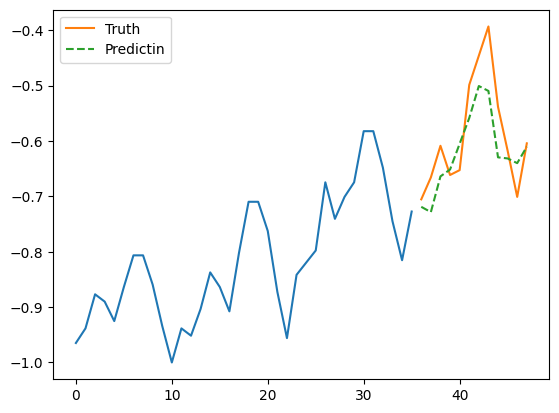

In [54]:
x, y = train_dataset[0]

x = torch.tensor(x).reshape(1,-1,1).float().to(device)
src_mask = model.generate_square_subsequent_mask(x.shape[1]).to(device)
pred = model(x, src_mask)

plt.plot(range(12*band), x.cpu().numpy().squeeze())
plt.plot(range(12*band, 12*band+12), y, label='Truth')
plt.plot(range(12*band, 12*band+12), pred.detach().cpu().numpy().squeeze(),  '--', label='Predictin')

plt.legend();

## Evaluation

In [29]:
def evaluate(input):
    model.eval()

    src_mask = model.generate_square_subsequent_mask(input.shape[1]).to(device)
    predictions = model(input, src_mask)

    return predictions.detach().cpu().numpy()

In [58]:
data_train

array([-0.96483516, -0.93846154, -0.87692308, -0.89010989, -0.92527473,
       -0.86373626, -0.80659341, -0.80659341, -0.85934066, -0.93406593,
       -1.        , -0.93846154, -0.95164835, -0.9032967 , -0.83736264,
       -0.86373626, -0.90769231, -0.8021978 , -0.70989011, -0.70989011,
       -0.76263736, -0.87252747, -0.95604396, -0.84175824, -0.81978022,
       -0.7978022 , -0.67472527, -0.74065934, -0.7010989 , -0.67472527,
       -0.58241758, -0.58241758, -0.64835165, -0.74505495, -0.81538462,
       -0.72747253, -0.70549451, -0.66593407, -0.60879121, -0.66153846,
       -0.65274725, -0.4989011 , -0.44615385, -0.39340659, -0.53846154,
       -0.61758242, -0.7010989 , -0.6043956 , -0.5956044 , -0.5956044 ,
       -0.41978022, -0.42417582, -0.45054945, -0.38901099, -0.2967033 ,
       -0.26153846, -0.41538462, -0.52967033, -0.66593407, -0.57362637,
       -0.56043956, -0.63076923, -0.42417582, -0.45934066, -0.42857143,
       -0.2967033 , -0.12967033, -0.16923077, -0.31868132, -0.45

In [59]:
data_train[-12*3:]

array([-0.07252747, -0.13406593,  0.10769231,  0.07252747,  0.1032967 ,
        0.3978022 ,  0.58681319,  0.5956044 ,  0.31868132,  0.06813187,
       -0.11648352,  0.01978022,  0.03736264, -0.05934066,  0.13406593,
        0.07252747,  0.13846154,  0.45494505,  0.7010989 ,  0.76263736,
        0.31868132,  0.12087912, -0.09450549,  0.02417582,  0.12527473,
        0.04615385,  0.32747253,  0.28351648,  0.38901099,  0.61758242,
        0.95164835,  1.        ,  0.57802198,  0.33186813,  0.13406593,
        0.32307692])

[0.09048959 0.14158024 0.3779466  0.45679873 0.6208538  0.7124323
 0.9837686  1.0337981  0.79617083 0.518668   0.2950077  0.23974963]
[[352.0864 ]
 [363.7095 ]
 [417.48285]
 [435.42172]
 [472.74426]
 [493.57837]
 [555.3074 ]
 [566.6891 ]
 [512.6289 ]
 [449.49698]
 [398.61426]
 [386.04303]]


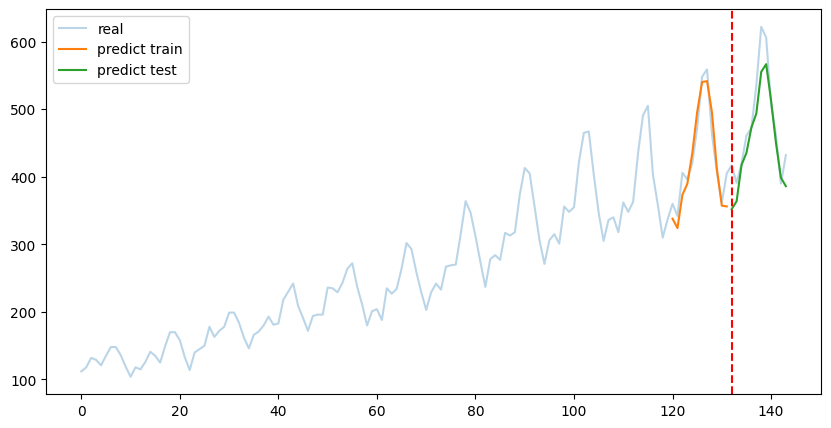

In [63]:
# 학습 세트에서 마지막 12개월을 예측하기 위한 입력
# 4년전부터 3년치가 입력 마지막 1년치가 타겟
input1 = torch.tensor(data_train[-12*(band+1):-12]).reshape(1,-1,1).to(device).float().to(device)

# 테스트 세트를 예측하기 위한 입력
# 학습세트의 마지막 3년치
input2 = torch.tensor(data_train[-12*band:]).reshape(1,-1,1).to(device).float().to(device)

result1 = evaluate(input1)
result1 = min_max_scaler.inverse_transform(result1.reshape(-1,1))

result2 = evaluate(input2)
print(result2)
result2 = min_max_scaler.inverse_transform(result2.reshape(-1,1))
print(result2)

real = air_passengers["Passengers"].to_numpy()

plt.figure(figsize=(10,5))
plt.plot(range(len(real)), real,  alpha=0.3, label="real")
plt.plot(range(len(data_train)-12, len(data_train)), result1, label="predict train")
plt.plot(range(len(data_train), len(data_train)+12), result2, label="predict test")
plt.axvline(x=len(real)-12, c='r', linestyle='--')

plt.legend()
plt.show()

In [64]:
def mape(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape(result2.reshape(-1), real[-12:])

5.8183072124796